In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

## Getting set up

In [2]:
comp = 'godaddy-microbusiness-density-forecasting'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
!ls godaddy-microbusiness-density-forecasting

census_starter.csv    test.csv
sample_submission.csv train.csv


Now we can import the stuff we'll need from fastai, set a seed (for reproducibility -- just for the purposes of making this notebook easier to write; I don't recommend doing that in your own analysis however) and check what's in the data:

In [4]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Looking at the data

In [5]:
df = pd.read_csv(path/'train.csv')

In [6]:
df['first_day_of_month'] =  pd.to_datetime(df['first_day_of_month'])

In [7]:
df_state_info = df[['cfips','county','state']].set_index('cfips').drop_duplicates()
county_one_hot = pd.get_dummies(df_state_info.county)
state_one_hot = pd.get_dummies(df_state_info.state)
df_state_info_one_hot = county_one_hot.join(state_one_hot,rsuffix='_st')

In [8]:
df = df.drop(['county','state'],axis=1)

In [9]:
census = pd.read_csv(path/'census_starter.csv').set_index('cfips')
census = census.groupby(level=0).max()

In [10]:
census =census.reset_index()

In [11]:
# census['pct_foreign_born_2022']=None
# census['pct_college_2022']=None
# census['pct_bb_2022']=None
# census['pct_it_workers_2022']=None
# census['median_hh_inc_2022']=None
# census['pct_foreign_born_2023']=None
# census['pct_college_2023']=None
# census['pct_bb_2023']=None
# census['pct_it_workers_2023']=None
# census['median_hh_inc_2023']=None

In [12]:
    ft_cols=['pct_foreign_born','pct_college','pct_bb','pct_it_workers','median_hh_inc']
    l = [[col for col in census.columns if col.startswith(pattern)] for pattern in ft_cols]
    flat_list = [item for sublist in l for item in sublist]

In [13]:
census_melted = pd.melt(census,id_vars=['cfips'],value_vars=flat_list
       )

In [14]:
census_melted['metric']=census_melted.variable.str.slice(stop=-5)
census_melted['year']=census_melted.variable.str.slice(start=-4).astype('int')

In [15]:
census_melted=census_melted[['cfips','year','metric','value']]

In [16]:
census_final = census_melted.pivot(index=['cfips','year'],columns=['metric'],values=['value'])

In [17]:
census_final.columns=['median_hh_inc','pct_bb','pct_college','pct_foreign_born','pct_it_workers']

In [18]:
for col in ft_cols:
    census_final[col+'_lag_1']=census_final[col].shift(-1)
    census_final[col+'_lag_2']=census_final[col].shift(-2)
    census_final[col+'_lag_3']=census_final[col].shift(-3)
    census_final[col+'_3y_mean']=census_final[[col+'_lag_1',col+'_lag_2',col+'_lag_3']].mean(axis=1)

In [19]:
census_final

median_hh_inc  pct_bb  pct_college  pct_foreign_born  \
cfips year                                                         
1001  2017        55317.0    76.6         14.5               2.1   
      2018        58786.0    78.9         15.9               2.0   
      2019        58731.0    80.6         16.1               2.3   
      2020        57982.0    82.7         16.7               2.3   
      2021        62660.0    85.5         16.4               2.1   
...                   ...     ...          ...               ...   
56045 2017        59605.0    71.1         14.1               3.8   
      2018        52867.0    73.3         13.5               4.1   
      2019        57031.0    76.8         13.4               1.7   
      2020        53333.0    79.7         12.7               2.3   
      2021        65566.0    81.3         13.9               1.6   

            pct_it_workers  pct_foreign_born_lag_1  pct_foreign_born_lag_2  \
cfips year                                                                   
1001  2017             1.3                     2.0                     2.3   
      2018             1.1                     2.3                     2.3   
      2019             0.7                     2.3                     2.1   
      2020             0.6                     2.1                     3.2   
      2021             1.1                     3.2                     3.4   
...                    ...                     ...                     ...   
56045 2017             0.6                     4.1                     1.7   
      2018             0.6                     1.7                     2.3   
      2019             0.0                     2.3                     1.6   
      2020             0.0                     1.6                     NaN   
      2021             0.0                     NaN                     NaN   

            pct_foreign_born_lag_3  pct_foreign_born_3y_mean  \
cfips year                                                     
1001  2017                     2.3                  2.200000   
      2018                     2.1                  2.233333   
      2019                     3.2                  2.533333   
      2020                     3.4                  2.900000   
      2021                     3.7                  3.433333   
...                            ...                       ...   
56045 2017                     2.3                  2.700000   
      2018                     1.6                  1.866667   
      2019                     NaN                  1.950000   
      2020                     NaN                  1.600000   
      2021                     NaN                       NaN   

            pct_college_lag_1  ...  pct_bb_lag_3  pct_bb_3y_mean  \
cfips year                     ...                                 
1001  2017               15.9  ...          82.7       80.733333   
      2018               16.1  ...          85.5       82.933333   
      2019               16.7  ...          74.5       80.900000   
      2020               16.4  ...          78.1       79.366667   
      2021               20.4  ...          81.8       78.133333   
...                       ...  ...           ...             ...   
56045 2017               13.5  ...          79.7       76.600000   
      2018               13.4  ...          81.3       79.266667   
      2019               12.7  ...           NaN       80.500000   
      2020               13.9  ...           NaN       81.300000   
      2021                NaN  ...           NaN             NaN   

            pct_it_workers_lag_1  pct_it_workers_lag_2  pct_it_workers_lag_3  \
cfips year                                                                     
1001  2017                   1.1                   0.7                   0.6   
      2018                   0.7                   0.6                   1.1   
      2019                   0.6                   1.1                   1

In [20]:
def _get_mean(df,pattern):
    l = [col for col in df.columns if col.startswith(pattern)]
    return df[l].mean(axis=1)

In [21]:
census_final = census_final.join(state_one_hot.add_prefix('st_'))

In [22]:
census_final

median_hh_inc  pct_bb  pct_college  pct_foreign_born  \
cfips year                                                         
1001  2017        55317.0    76.6         14.5               2.1   
      2018        58786.0    78.9         15.9               2.0   
      2019        58731.0    80.6         16.1               2.3   
      2020        57982.0    82.7         16.7               2.3   
      2021        62660.0    85.5         16.4               2.1   
...                   ...     ...          ...               ...   
56045 2017        59605.0    71.1         14.1               3.8   
      2018        52867.0    73.3         13.5               4.1   
      2019        57031.0    76.8         13.4               1.7   
      2020        53333.0    79.7         12.7               2.3   
      2021        65566.0    81.3         13.9               1.6   

            pct_it_workers  pct_foreign_born_lag_1  pct_foreign_born_lag_2  \
cfips year                                                                   
1001  2017             1.3                     2.0                     2.3   
      2018             1.1                     2.3                     2.3   
      2019             0.7                     2.3                     2.1   
      2020             0.6                     2.1                     3.2   
      2021             1.1                     3.2                     3.4   
...                    ...                     ...                     ...   
56045 2017             0.6                     4.1                     1.7   
      2018             0.6                     1.7                     2.3   
      2019             0.0                     2.3                     1.6   
      2020             0.0                     1.6                     NaN   
      2021             0.0                     NaN                     NaN   

            pct_foreign_born_lag_3  pct_foreign_born_3y_mean  \
cfips year                                                     
1001  2017                     2.3                  2.200000   
      2018                     2.1                  2.233333   
      2019                     3.2                  2.533333   
      2020                     3.4                  2.900000   
      2021                     3.7                  3.433333   
...                            ...                       ...   
56045 2017                     2.3                  2.700000   
      2018                     1.6                  1.866667   
      2019                     NaN                  1.950000   
      2020                     NaN                  1.600000   
      2021                     NaN                       NaN   

            pct_college_lag_1  ...  st_South Dakota  st_Tennessee  st_Texas  \
cfips year                     ...                                            
1001  2017               15.9  ...              0.0           0.0       0.0   
      2018               16.1  ...              0.0           0.0       0.0   
      2019               16.7  ...              0.0           0.0       0.0   
      2020               16.4  ...              0.0           0.0       0.0   
      2021               20.4  ...              0.0           0.0       0.0   
...                       ...  ...              ...           ...       ...   
56045 2017               13.5  ...              0.0           0.0       0.0   
      2018               13.4  ...              0.0           0.0       0.0   
      2019               12.7  ...              0.0           0.0       0.0   
      2020               13.9  ...              0.0           0.0       0.0   
      2021                NaN  ...              0.0           0.0       0.0   

            st_Utah  st_Vermont  st_Virginia  st_Washington  st_West Virginia  \
cfips year                                                                      
1001  2017      0.0         0.0          0.0            0.0               0.0   
      20

## Adding code for census_v1 for no time window

In [23]:
census_v1 = census.set_index('cfips').drop_duplicates()
census_v1['median_hh_inc_mean'] = _get_mean(census_v1,'median_hh_inc_')
census_v1['pct_foreign_born_mean'] = _get_mean(census_v1,'pct_foreign_born')
census_v1['pct_college_mean'] = _get_mean(census_v1,'pct_college')
census_v1['pct_it_workers_mean'] = _get_mean(census_v1,'pct_it_workers_')
census_v1 = census_v1.join(state_one_hot.add_prefix('st_'))

In [24]:
census_v1

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,...,st_South Dakota,st_Tennessee,st_Texas,st_Utah,st_Vermont,st_Virginia,st_Washington,st_West Virginia,st_Wisconsin,st_Wyoming
cfips,,,,,,,,,,,,,,,,,,,,,
1001,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,74.5,78.1,81.8,85.1,87.9,20.4,20.7,21.0,20.2,20.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,57.2,60.4,60.5,64.6,64.6,7.6,7.8,7.6,7.3,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,62.0,66.1,69.2,76.1,74.6,8.1,7.6,6.5,7.4,7.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009,65.8,68.5,73.0,79.6,81.0,8.7,8.1,8.6,8.9,9.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,82.2,82.4,84.0,86.7,88.4,15.3,15.2,14.8,13.7,12.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
56039,83.5,85.9,87.1,89.1,90.5,37.7,37.8,38.9,37.2,38.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
56041,83.8,88.2,89.5,91.4,90.6,11.9,10.5,11.1,12.6,12.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Feature engineering

In [25]:
dep='microbusiness_density'
def xs_y(df):
    # df[cats] = df[cats].apply(lambda x: x.cat.codes)
    xs = df[set(df.columns)-set([dep])].fillna(0)
    return xs,df[dep] if dep in df else None

# trn_xs,trn_y = xs_y(trn_df)
# val_xs,val_y = xs_y(val_df)

In [26]:
df

,row_id,cfips,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,2019-12-01,2.993233,1243
...,...,...,...,...,...
122260,56045_2022-06-01,56045,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,2022-09-01,1.785395,100


In [27]:
def _select_cols(df,ft_cols):
#     ft_cols=['pct_foreign_born_3y_mean','pct_college_3y_mean']+[
    l = [[col for col in df.columns if col.startswith(pattern)] for pattern in ft_cols]
    flat_list = [item for sublist in l for item in sublist]
    return df[flat_list]

def feature_engineering(df):
    ft_cols=['pct_foreign_born_3y_mean','pct_college_3y_mean']+[
        'first_day_of_month','st_','month','year',dep]
    df['year'] = df.first_day_of_month.dt.year
    df['month'] = df.first_day_of_month.dt.month
    df = df.set_index(['cfips','year'])
    df = df.join(census_final)
#     return df
    return _select_cols(df,ft_cols)


def feature_engineering_v1(df):
    ft_cols=['pct_foreign_born_mean','pct_college_mean']+[
        'first_day_of_month','st_','month','year',dep]
    df['year'] = df.first_day_of_month.dt.year
    df['month'] = df.first_day_of_month.dt.month
    df = df.set_index(['cfips'])
    df = df.join(census_v1)
#     return df
    return _select_cols(df,ft_cols)


df_ft_v1 = feature_engineering_v1(df)
df_ft = feature_engineering(df)
# proc_data(tst_df)

In [28]:
df_ft_v1.head(3)

,pct_foreign_born_mean,pct_college_mean,first_day_of_month,st_Alabama,st_Alaska,st_Arizona,st_Arkansas,st_California,st_Colorado,st_Connecticut,...,st_Utah,st_Vermont,st_Virginia,st_Washington,st_West Virginia,st_Wisconsin,st_Wyoming,month,year,microbusiness_density
cfips,,,,,,,,,,,,,,,,,,,,,
1001,2.16,15.92,2019-08-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,2019,3.007682
1001,2.16,15.92,2019-09-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2019,2.884870
1001,2.16,15.92,2019-10-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,2019,3.055843


In [29]:
df_ft.head(3)

pct_foreign_born_3y_mean  pct_college_3y_mean first_day_of_month  \
cfips year                                                                     
1001  2019                  2.533333            17.833333         2019-08-01   
      2019                  2.533333            17.833333         2019-09-01   
      2019                  2.533333            17.833333         2019-10-01   

            st_Alabama  st_Alaska  st_Arizona  st_Arkansas  st_California  \
cfips year                                                                  
1001  2019         1.0        0.0         0.0          0.0            0.0   
      2019         1.0        0.0         0.0          0.0            0.0   
      2019         1.0        0.0         0.0          0.0            0.0   

            st_Colorado  st_Connecticut  ...  st_Texas  st_Utah  st_Vermont  \
cfips year                               ...                                  
1001  2019          0.0             0.0  ...       0.0      0.0         0.0   
      2019          0.0             0.0  ...       0.0      0.0         0.0   
      2019          0.0             0.0  ...       0.0      0.0         0.0   

            st_Virginia  st_Washington  st_West Virginia  st_Wisconsin  \
cfips year                                                               
1001  2019          0.0            0.0               0.0           0.0   
      2019          0.0            0.0               0.0           0.0   
      2019          0.0            0.0               0.0           0.0   

            st_Wyoming  month  microbusiness_density  
cfips year                                            
1001  2019         0.0      8               3.007682  
      2019         0.0      9               2.884870  
      2019         0.0     10               3.055843  

[3 rows x 56 columns]

In [30]:
# m = DecisionTreeClassifier(min_samples_leaf=50)
# m.fit(trn_xs, trn_y)
# draw_tree(m, trn_xs, size=25)

## Our first model

In [31]:
df_ft=df_ft_v1

In [32]:
test_set = list(df_ft.first_day_of_month.drop_duplicates().sort_values().tail(3))

In [33]:
from sklearn.model_selection import train_test_split
# trn_df,val_df = train_test_split(df_ft, test_size=0.25)
trn_df = df_ft[~df_ft.first_day_of_month.isin(test_set)].drop('first_day_of_month',axis=1)
val_df = df_ft[df_ft.first_day_of_month.isin(test_set)].drop('first_day_of_month',axis=1)

In [34]:
trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

/var/folders/5x/sh4xsr052rvdh1ft462t40fr0000gn/T/ipykernel_28444/749896921.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xs = df[set(df.columns)-set([dep])].fillna(0)
/var/folders/5x/sh4xsr052rvdh1ft462t40fr0000gn/T/ipykernel_28444/749896921.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xs = df[set(df.columns)-set([dep])].fillna(0)


In [35]:
trn_y.head(5)

cfips
1001    3.007682
1001    2.884870
1001    3.055843
1001    2.993233
1001    2.993233
Name: microbusiness_density, dtype: float64

In [36]:
trn_xs.head(5)

,st_Illinois,st_Wyoming,st_Indiana,st_Tennessee,st_Utah,st_Pennsylvania,st_Ohio,st_Mississippi,st_Michigan,st_Arkansas,...,st_North Carolina,pct_college_mean,st_Massachusetts,st_Montana,st_Maryland,pct_foreign_born_mean,st_New Mexico,st_New Hampshire,st_Alaska,st_Virginia
cfips,,,,,,,,,,,,,,,,,,,,,
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0


In [37]:
val_xs.head(5)

,st_Illinois,st_Wyoming,st_Indiana,st_Tennessee,st_Utah,st_Pennsylvania,st_Ohio,st_Mississippi,st_Michigan,st_Arkansas,...,st_North Carolina,pct_college_mean,st_Massachusetts,st_Montana,st_Maryland,pct_foreign_born_mean,st_New Mexico,st_New Hampshire,st_Alaska,st_Virginia
cfips,,,,,,,,,,,,,,,,,,,,,
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,20.58,0.0,0.0,0.0,3.44,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,20.58,0.0,0.0,0.0,3.44,0.0,0.0,0.0,0.0


In [38]:
#!pip install xgboost

In [39]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

model = xgb.XGBRegressor(booster='gbtree',eval_metric='rmse', random_state=42, n_estimators=5000,max_depth=300)
# rf = RandomForestRegressor(20, min_samples_leaf=5)
model.fit(trn_xs, trn_y);

In [40]:
def calculate_smape(actual, predicted) -> float:
  
    # Convert actual and predicted to numpy
    # array data type if not already
    actual = np.array(actual)
    predicted = np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

In [41]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
print(mean_absolute_error(val_y, model.predict(val_xs)))
print(calculate_smape(val_y, model.predict(val_xs)))
#0.41052609347118274,0.40696198003785405,0.2451427168038899,2.58,0.1322,
#8.6,8.48,4.7,62.16,2.2

0.13226925848031734
2.2


In [42]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=model.feature_importances_)).sort_values('imp')

,cols,imp
35,st_Alabama,0.000109
18,st_Connecticut,0.000111
32,st_Rhode Island,0.000123
6,st_Ohio,0.000180
5,st_Pennsylvania,0.000204
12,st_West Virginia,0.000205
17,st_Kentucky,0.000211
7,st_Mississippi,0.000292
9,st_Arkansas,0.000303
8,st_Michigan,0.000311


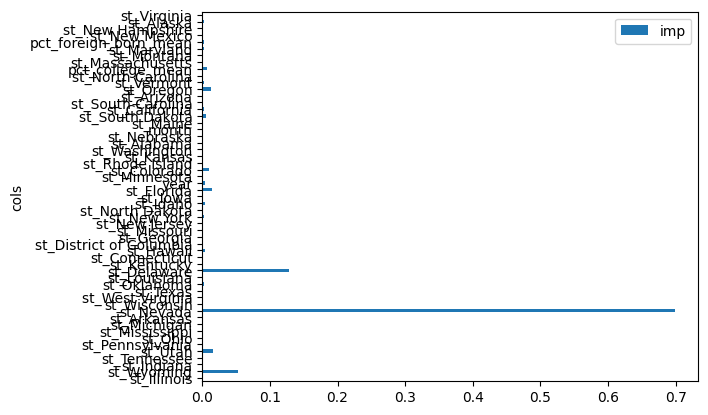

In [43]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=model.feature_importances_)).plot('cols', 'imp', 'barh');

## Submitting to Kaggle

In [44]:
test_df = pd.read_csv(path/'test.csv')

In [45]:
test_df['first_day_of_month'] =  pd.to_datetime(test_df['first_day_of_month'])

In [46]:
test_df

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01
...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01
25076,56039_2023-06-01,56039,2023-06-01
25077,56041_2023-06-01,56041,2023-06-01
25078,56043_2023-06-01,56043,2023-06-01


In [47]:
test_df_ft = feature_engineering_v1(test_df).drop('first_day_of_month',axis=1)

In [48]:
test_xs = xs_y(test_df_ft)[0]

/var/folders/5x/sh4xsr052rvdh1ft462t40fr0000gn/T/ipykernel_28444/749896921.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xs = df[set(df.columns)-set([dep])].fillna(0)


In [49]:
test_xs.head(100)

,st_Illinois,st_Wyoming,st_Indiana,st_Tennessee,st_Utah,st_Pennsylvania,st_Ohio,st_Mississippi,st_Michigan,st_Arkansas,...,st_North Carolina,pct_college_mean,st_Massachusetts,st_Montana,st_Maryland,pct_foreign_born_mean,st_New Mexico,st_New Hampshire,st_Alaska,st_Virginia
cfips,,,,,,,,,,,,,,,,,,,,,
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.92,0.0,0.0,0.0,2.16,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.02,0.0,0.0,0.0,0.64,0.0,0.0,0.0,0.0
1025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.10,0.0,0.0,0.0,0.40,0.0,0.0,0.0,0.0
1025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.10,0.0,0.0,0.0,0.40,0.0,0.0,0.0,0.0


In [50]:
test_df['microbusiness_density'] = model.predict(test_xs)

In [51]:
result = test_df[['row_id','microbusiness_density']]

In [52]:
result.to_csv('subm.csv', index=False)
!head subm.csv

row_id,microbusiness_density
1001_2022-11-01,3.4379523
1003_2022-11-01,3.4379747
1005_2022-11-01,3.2972243
1007_2022-11-01,3.334381
1009_2022-11-01,3.338958
1011_2022-11-01,3.3704965
1013_2022-11-01,3.3148324
1015_2022-11-01,3.3465044
1017_2022-11-01,8.571875


Let's submit this to kaggle. We can do it from the notebook if we're running on Kaggle, otherwise we can use the API:

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'xgb model w mean', comp)

Success! We successfully created a submission.

## Conclusion

## Addendum

`fastkaggle` also provides a function that pushes a notebook to Kaggle Notebooks. I wrote this notebook on my own machine, and pushed it to Kaggle from there -- here's the command I used:

In [ ]:
if not iskaggle:
    push_notebook('madhaowagh', 'rf model updated',
                  title='starter notebook ',
                  file='rf_model_v1.ipynb',
                  competition=comp, private=False, gpu=False)